In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

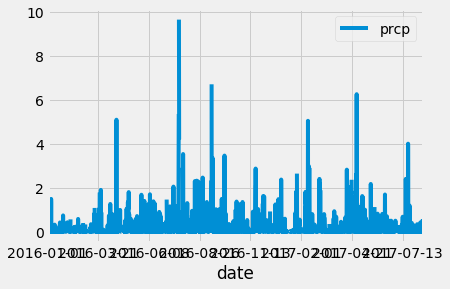

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date=session.query(func.strftime("%Y-%m-%d",Measurement.date)).order_by(Measurement.date.desc()).first()
last_date=last_date[0].split('-')
year=int(last_date[0])
month=int(last_date[1])
day=int(last_date[2])

last_year=year-1

date=dt.date(last_year,month,day)


# Perform a query to retrieve the data and precipitation scores
prcp=session.query(Measurement.prcp,Measurement.date).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df=pd.DataFrame(prcp)
prcp_df.head()
# Sort the dataframe by date
prcp_df=prcp_df.sort_values('date')
prcp_df
# Use Pandas Plotting with Matplotlib to plot the data
ax=prcp_df.plot(kind='line',x='date',y='prcp')
fig=ax.get_figure()
fig.savefig('Images/precipitation.png')

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary=prcp_df.describe()
summary

,prcp
count,3336.000000
mean,0.174559
std,0.487085
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,9.640000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(Station.id).count()
station_count

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations=session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active=active_stations[0]
most_active=most_active[0]
print(most_active)
temp=session.query(Measurement.tobs).filter(Measurement.station==most_active).all()
highest_temp=max(temp)
lowest_temp=min(temp)
avg_temp=np.mean(temp)
print(highest_temp)
print(lowest_temp)
print(avg_temp)


USC00519281
(85.0,)
(54.0,)
71.66378066378067


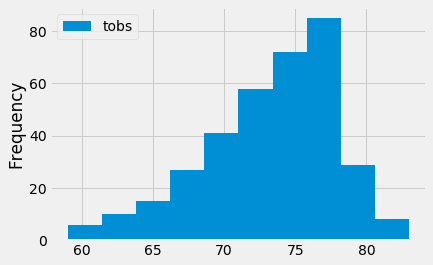

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_temp_obs=session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
temp_year=session.query(Measurement.tobs).filter(Measurement.date>'2016-08-23').filter(Measurement.station==most_active).all()
temp_year_df=pd.DataFrame(temp_year)
ax=temp_year_df.plot(kind='hist')
fig=ax.get_figure()
fig.savefig('Images/hist_station.png')

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp=calc_temps('2012-02-28', '2012-03-05')
trip_temp=trip_temp[0]
trip_temp

(62.0, 69.57142857142857, 74.0)

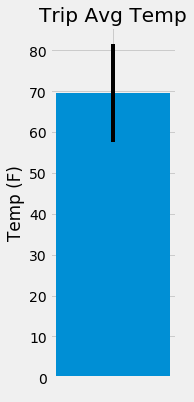

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
ax=plt.subplots(figsize=(2,6))
varr=trip_temp[2]-trip_temp[0]
plt.bar(' ',trip_temp[1],yerr=varr)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.savefig('Images/temperature')

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_rain=session.query(Measurement.station,func.sum(Measurement.prcp),Station.name,Station.latitude,Station.longitude,Station.elevation).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).join(Station,Station.station==Measurement.station).all()
total_rain

[('USC00516128',
  1068.0899999999956,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  588.6399999999976,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117',
  382.61999999999847,
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6),
 ('USC00519523',
  295.67999999999944,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  234.49000000000026,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519397',
  131.62000000000063,
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00511918',
  92.68000000000006,
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9),
 ('USC00518838',
  70.87000000000005,
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6),
 ('USC00517948',
  43.44000000000002,
  'PEARL CITY, HI US',
  21.3934,
  -157.9751,
  11.9)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date=dt.date(2012,2,28)
end_date=dt.date(2012,3,5)
# Use the start and end date to create a range of dates
date_list=[]
date=start_date
while date!=end_date:
    date_list.append(date)
    date=date+dt.timedelta(days=1)
date_list.append(end_date)

# Stip off the year and save a list of %m-%d strings
formated_date_list=[]
for date in date_list:
    date=date.strftime('%m-%d')
    formated_date_list.append(date)
formated_date_list
# Loop through the list of %m-%d strings and calculate the normals for each date
temp_list=[]
for day in formated_date_list:
    temp=daily_normals(day)
    temp=temp[0]
    temp_list.append(temp)


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
date_temp_df=pd.DataFrame(temp_list,columns=['temp_min','temp_avg','temp_max'],index=formated_date_list)
date_temp_df

,temp_min,temp_avg,temp_max
02-28,65.0,70.655172,80.0
02-29,67.0,71.733333,79.0
03-01,64.0,70.032787,76.0
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0
03-05,60.0,67.890909,76.0


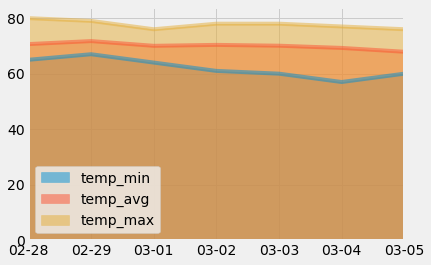

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
ax=date_temp_df.plot(kind='area',stacked=False)
fig=ax.get_figure()
fig.savefig('Images/daily_normals.png')